## Week 10 Homework

---

### Q1: perform Bayesian Logistic Regression 

- For a binary outcome dataset you find interesting (perhaps from kaggle.com?)
- Model the outcome as a bernoulli random variable and use a **logit link** function
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than the `pm.MvNormal` version
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
binary_data = pd.read_csv("binary.csv")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, intercept]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]    0.263  0.127   0.042    0.508      0.003    0.002    1951.0   
beta[1]    0.299  0.124   0.072    0.530      0.003    0.002    1948.0   
beta[2]   -0.528  0.118  -0.752   -0.316      0.003    0.002    2050.0   
intercept -0.855  0.116  -1.075   -0.634      0.003    0.002    1832.0   

           ess_tail  r_hat  
beta[0]      1715.0    1.0  
beta[1]      1584.0    1.0  
beta[2]      1650.0    1.0  
intercept    1628.0    1.0  


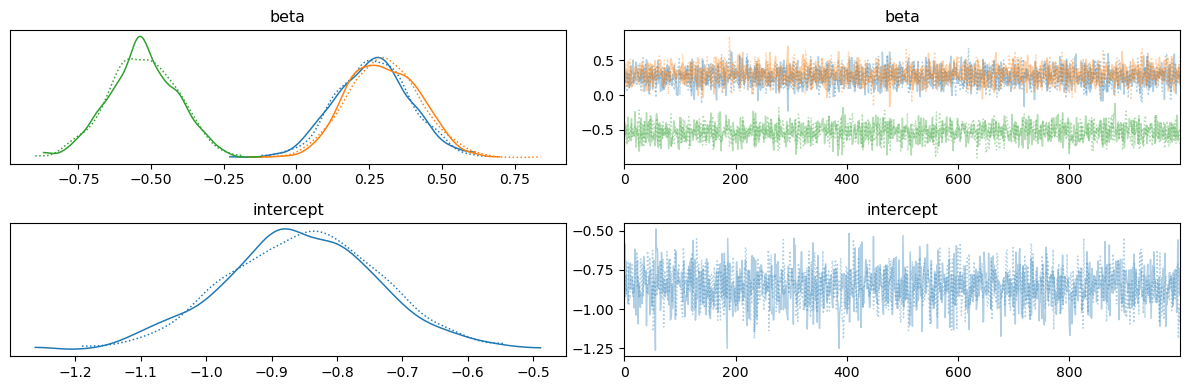

In [3]:
# Prepare data for modeling
X = binary_data[['gre', 'gpa', 'rank']].values  # Predictor variables
y = binary_data['admit'].values  # Binary outcome

# Standardize predictors for better sampling
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_standardized = (X - X_mean) / X_std

# Bayesian Logistic Regression using PyMC
with pm.Model() as logistic_model:
    # Priors for regression coefficients (betas) and intercept
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X.shape[1])
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Logistic regression model
    logit_p = intercept + pm.math.dot(X_standardized, beta)
    p = pm.math.sigmoid(logit_p)  # Logit link function

    # Likelihood (Bernoulli outcome)
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y)

    # Perform MCMC sampling with optimized settings
    trace = pm.sample(1000, tune=500, return_inferencedata=True, target_accept=0.9, cores=1)

# Display posterior summaries
print(az.summary(trace))

# Plot trace and posterior distributions for the parameters
az.plot_trace(trace)
plt.tight_layout()
plt.show()

### Q2: perform Bayesian Multivariate Regression

- For a data set for which modeling multiple continuous outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


In [13]:
df = pd.read_csv("california_housing.csv", nrows=2000)
df = df.dropna()
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [14]:
# Define predictor variables (X)
predictor_cols = ["longitude", "latitude", "housing_median_age", 
                  "total_rooms", "total_bedrooms", "population", 
                  "households", "median_income"]

# Define response variables (Y) (multiple outcomes)
response_cols = ["median_house_value", "median_income"]

# Convert categorical variable "ocean_proximity" to numerical encoding (if applicable)
if "ocean_proximity" in df.columns:
    df["ocean_proximity"] = df["ocean_proximity"].astype("category").cat.codes
    predictor_cols.append("ocean_proximity")

# Extract predictor and response variables
X_full = df[predictor_cols].values  # (N, p)
Y_full = df[response_cols].values    # (N, m)

In [15]:
# Downsample to different sizes
sample_sizes = [(300, 5, 2), (500, 8, 2), (1000, 10, 3)]  # (n, p, m)

for (n, p, m) in sample_sizes:
    print(f"Testing Bayesian Regression with (n={n}, p={p}, m={m})")
    
    # Randomly sample `n` rows
    sampled_df = df.sample(n=n, random_state=42)

    # Extract sampled data
    X = sampled_df[predictor_cols[:p]].values  # First `p` predictors
    Y = sampled_df[response_cols[:m]].values   # First `m` response variables

    # Standardize predictors
    X_mean, X_std = X.mean(axis=0), X.std(axis=0)
    X_standardized = (X - X_mean) / X_std

    # Report statistics
    print(f"Mean of X: {X_mean}")
    print(f"Mean of Y: {Y.mean(axis=0)}")
    print("-" * 50)


Testing Bayesian Regression with (n=300, p=5, m=2)
Mean of X: [-121.95813333   38.0947       30.82666667 2729.24333333  541.25      ]
Mean of Y: [1.8222334e+05 3.6940200e+00]
--------------------------------------------------
Testing Bayesian Regression with (n=500, p=8, m=2)
Mean of X: [-121.97018     38.05128     31.726     2664.956      520.014
 1300.882      484.26         3.8077096]
Mean of Y: [1.87766214e+05 3.80770960e+00]
--------------------------------------------------
Testing Bayesian Regression with (n=1000, p=10, m=3)
Mean of X: [-1.2195714e+02  3.8057710e+01  3.1420000e+01  2.6724600e+03
  5.1128600e+02  1.2726130e+03  4.7564000e+02  3.9337000e+00
  1.6160000e+00]
Mean of Y: [1.94163314e+05 3.93370000e+00]
--------------------------------------------------


In [16]:
# Choose final dataset size based on exploration
n, p, m = 500, 8, 2

# Sample `n` rows for the final model
sampled_df = df.sample(n=n, random_state=42)

# Extract predictors and responses
X = sampled_df[predictor_cols[:p]].values  # First `p` predictors
Y = sampled_df[response_cols[:m]].values   # First `m` response variables

# Standardize predictors
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_standardized = (X - X_mean) / X_std

# Bayesian Model
with pm.Model() as MNV_LKJ:
    
    # LKJ prior for covariance matrix
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    
    # Priors for regression coefficients
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))
    
    # Compute covariance matrix
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    
    # Multivariate normal likelihood
    y = pm.MvNormal('y', mu=X_standardized @ betas, chol=L, observed=Y)   
    
    # Sample from the posterior
    trace = pm.sample(1000, tune=500, return_inferencedata=True, target_accept=0.9)

# Posterior Summary
summary = az.summary(trace)
print(summary)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 311 seconds.


                     mean           sd        hdi_3%       hdi_97%  mcse_mean  \
Sigma[0, 0]  7.764942e+08  5450038.780  7.665579e+08  7.870955e+08  83398.501   
Sigma[0, 1]  1.458531e+04      209.727  1.420057e+04  1.498140e+04      3.522   
Sigma[1, 0]  1.458531e+04      209.727  1.420057e+04  1.498140e+04      3.522   
Sigma[1, 1]  1.363000e+00        0.070  1.239000e+00  1.491000e+00      0.001   
betas[0, 0]  2.400000e-02        1.004 -1.904000e+00  1.869000e+00      0.015   
betas[0, 1]  1.270000e-01        0.056  2.200000e-02  2.280000e-01      0.001   
betas[1, 0] -2.600000e-02        0.983 -1.830000e+00  1.879000e+00      0.015   
betas[1, 1]  1.740000e-01        0.052  7.900000e-02  2.740000e-01      0.001   
betas[2, 0] -1.400000e-02        1.011 -1.964000e+00  1.831000e+00      0.014   
betas[2, 1] -1.980000e-01        0.058 -3.130000e-01 -9.500000e-02      0.001   
betas[3, 0] -1.000000e-03        0.962 -1.793000e+00  1.847000e+00      0.013   
betas[3, 1]  3.000000e-03   

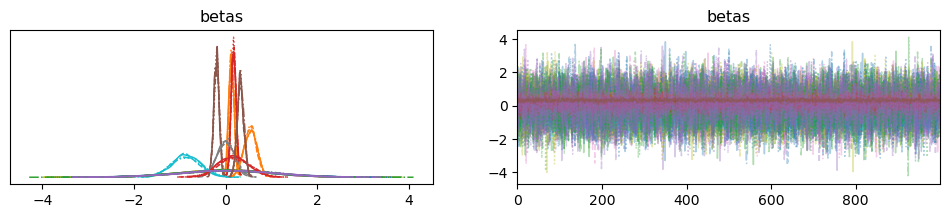

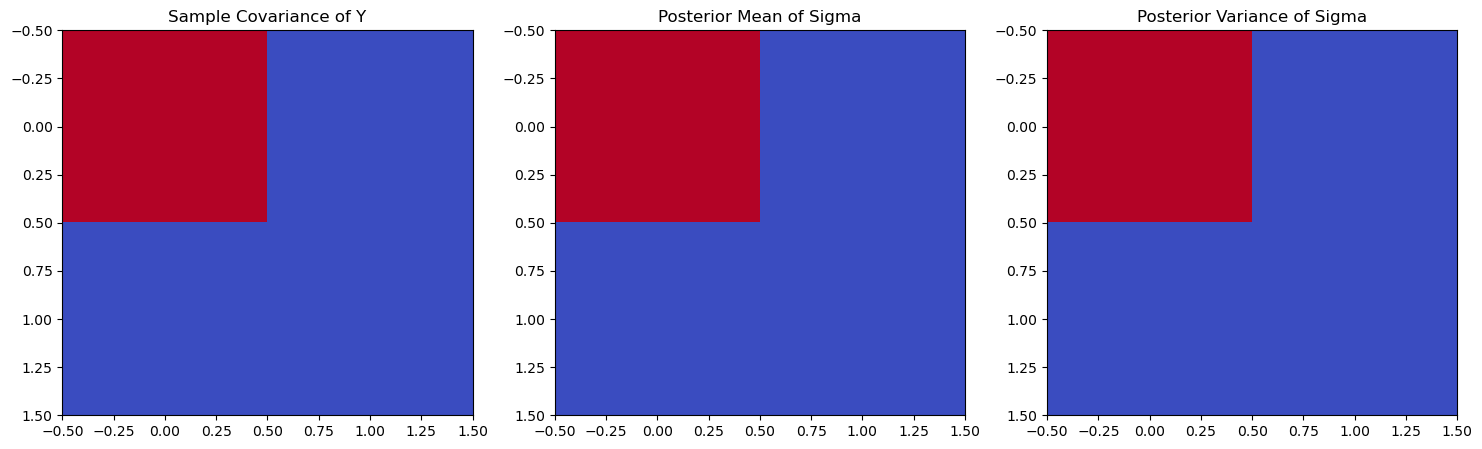

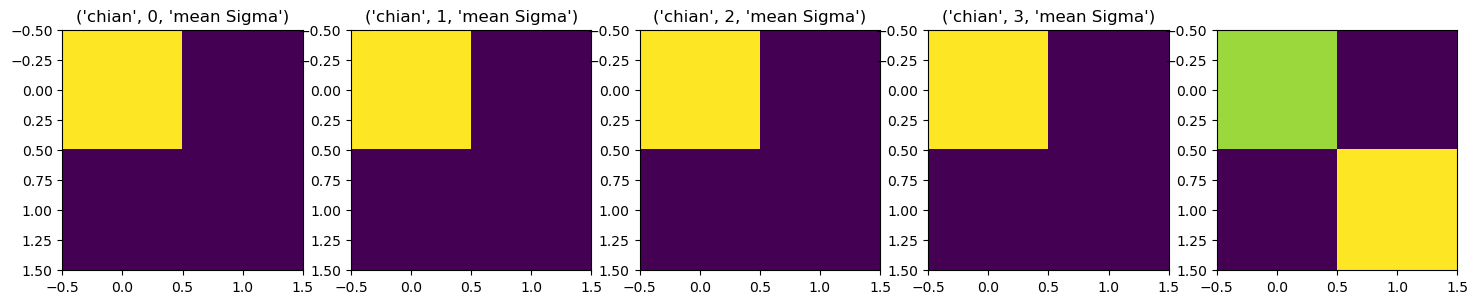

In [27]:
import scipy.stats as stats

# Plot MCMC Diagnostics
az.plot_trace(trace, var_names=['betas'])

# Visualize covariance matrix estimation
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# True sample covariance matrix
ax[0].imshow(np.cov(Y, rowvar=False), cmap="coolwarm", aspect='auto')
ax[0].set_title("Sample Covariance of Y")

# Posterior mean covariance
ax[1].imshow(trace.posterior['Sigma'].mean(dim=["chain", "draw"]), cmap="coolwarm", aspect='auto')
ax[1].set_title("Posterior Mean of Sigma")

# Posterior variance estimate
ax[2].imshow(np.var(trace.posterior['Sigma'], axis=(0,1)), cmap="coolwarm", aspect='auto')
ax[2].set_title("Posterior Variance of Sigma")

plt.show()

a_cov = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()

fig,ax = plt.subplots(1,5,figsize=(18,4))
ax[-1].imshow(a_cov)
ax[0].set_title(("Sigma used to generate y"))
for chain in range(4):
    ax[chain].imshow(trace.posterior['Sigma'].mean(axis=1)[chain])
    ax[chain].set_title(("chian",chain,"mean Sigma"))

### Q3: perform Bayesian Multivariate Classification

- For a data set for which modeling multiple binary outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Use latent `z = pm.MvNormal('z', mu=X@betas, chol=L)` as discussed in the "Generalized Linear Models (GLM)" section of the previous weeks lecture notes

> This provides normally distributed latent variables connected to the observed binary outcomes on which a latent covariance dependency structure may be modelled and estimated on the basis of imputing the unobserved latent variables based on their connection with the observed binary outcome variables.

- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


In [30]:
multi_data = pd.read_csv("multiple binary.csv")
multi_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [33]:
selected_columns = ["Survived", "Age", "SibSp", "Parch", "Ticket", "Fare"]
filtered_data = multi_data[selected_columns].dropna()


In [36]:
# Encode "Ticket" as numerical
filtered_data["Ticket"] = pd.factorize(filtered_data["Ticket"])[0]

# Create a second binary outcome: High Fare vs. Low Fare
filtered_data["High_Fare"] = (filtered_data["Fare"] > filtered_data["Fare"].median()).astype(int)

# Define X (predictors) and Y (binary outcomes)
X = filtered_data[["Age", "SibSp", "Parch", "Ticket", "Fare"]].values  # (n, p)
Y = filtered_data[["Survived", "High_Fare"]].values  # (n, m)

n, p = X.shape  # Number of samples & predictors
m = Y.shape[1]  # Number of binary outcomes

# Standardize X
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_std[X_std == 0] = 1  # Avoid division by zero
X_standardized = (X - X_mean) / X_std

# Bayesian Multivariate Classification Model
with pm.Model() as Multivariate_Classification:
    
    # LKJ Prior for covariance if m > 1
    if m > 1:
        packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                     sd_dist=pm.Exponential.dist(1.0), 
                                     compute_corr=False)
        L = pm.expand_packed_triangular(m, packed_L)
    else:
        L = pm.Deterministic("L", np.array([[1.0]]))  # Identity matrix if only 1 outcome
    
    # Reparameterized Priors for regression coefficients
    betas_raw = pm.Normal('betas_raw', mu=0, sigma=1, shape=(p, m))
    betas = pm.Deterministic("betas", betas_raw * 2)  # Scale to improve sampling
    
    # Latent variables
    z = pm.MvNormal('z', mu=X_standardized @ betas, chol=L, shape=(n, m))

    # Observed binary outcomes using inverse probit link
    y = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=Y)

    # Sample from posterior with higher target_accept
    idata = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Posterior Summary
summary = az.summary(idata)
print(summary)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas_raw, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 509 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3591 divergences after tuning. Increase `target_accept` or reparameterize.


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]  0.269  0.390  -0.198    0.836      0.192    0.070       5.0   
betas[0, 1]  0.237  0.143   0.017    0.421      0.065    0.031       6.0   
betas[1, 0] -0.131  0.926  -1.563    1.018      0.460    0.233       4.0   
betas[1, 1]  0.663  0.563   0.022    1.559      0.279    0.142       4.0   
betas[2, 0] -0.623  0.870  -1.811    0.317      0.432    0.123       5.0   
...            ...    ...     ...      ...        ...      ...       ...   
z[328, 1]   -1.156  0.863  -2.304    0.040      0.416    0.182       4.0   
z[329, 0]    1.307  1.055  -0.388    2.465      0.459    0.115       6.0   
z[329, 1]   -1.444  2.212  -3.859    1.109      1.098    0.089       5.0   
z[330, 0]   -0.098  1.214  -2.194    0.983      0.508    0.418       5.0   
z[330, 1]   -0.972  0.419  -1.509   -0.482      0.183    0.049       6.0   

             ess_tail  r_hat  
betas[0, 0]      39.0   2.52  
betas[0, 1]       4.0   3

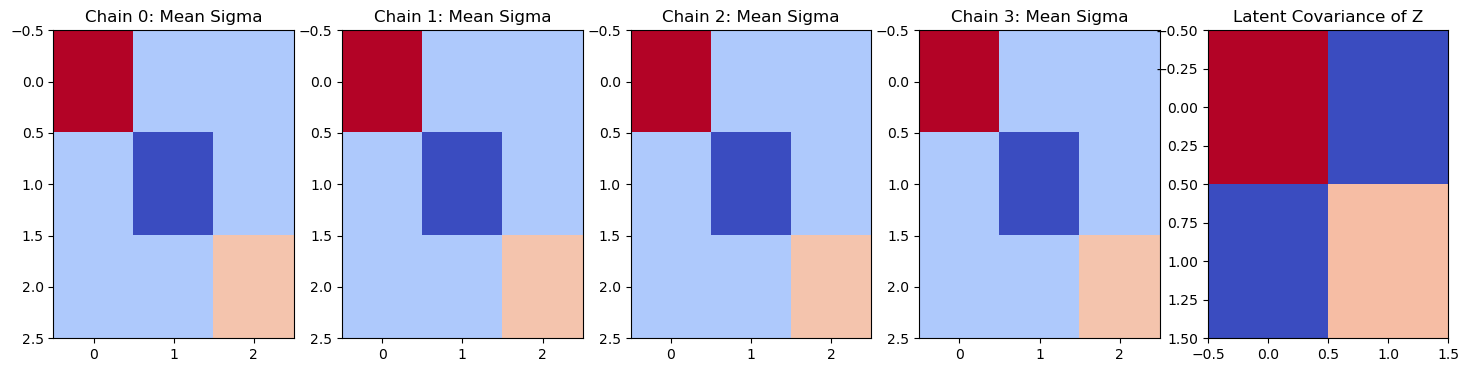

/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


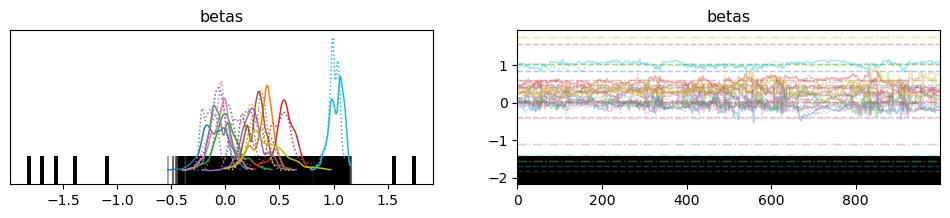

In [37]:
# Plot Posterior Covariance Estimates
fig, ax = plt.subplots(1, 5, figsize=(18, 4))

# Compute empirical covariance of latent variables Z
latent_cov = np.cov((X_standardized @ betas.eval()).T)

ax[4].imshow(latent_cov, cmap="coolwarm", aspect='auto')
ax[4].set_title("Latent Covariance of Z")

# Fix `packed_L` mean shape before plotting
sigma_mean = idata.posterior['packed_L'].mean(dim=["chain", "draw"]).values.squeeze()

for chain in range(4):
    if sigma_mean.ndim == 1:  # If single-dimensional, reshape manually
        sigma_matrix = np.diag(sigma_mean)  # Convert vector to diagonal matrix
    else:
        sigma_matrix = sigma_mean[chain]  # Use proper shape

    ax[chain].imshow(sigma_matrix, cmap="coolwarm", aspect='auto')
    ax[chain].set_title(f"Chain {chain}: Mean Sigma")

plt.show()

# Traceplot to check MCMC convergence
az.plot_trace(idata, var_names=['betas']);
plt.show()